In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../")
import lib

sys.path.append("../scripts/fit")
import hc3
import template



import matplotlib.pyplot as plt
#plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-nonrenewal-process/notebooks/../lib/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


This notebook contains classical analysis of linear track data.

### Loading data

In [2]:
# data
data_path = "../data/hc3/"
session_name = 'ec014.29_ec014.468_L-to-R'
max_ISI_order = 4

select_fracs = [0.0, 0.5]
dataset_dict = hc3.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

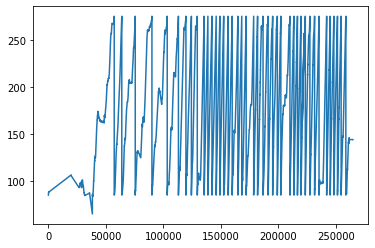

In [3]:
plt.plot(dataset_dict['covariates']['x'])
plt.show()

## Poisson point process

In [ ]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
ISI_orders = 4
name = 'ec014.29_ec014.468_L-to-RISI5sel0.0to0.5_isi4__nonparam_pp_gp-64-matern32-1000-12._X[x-theta]_Z[]'.format(ISI_orders)


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()

st = 0
xs = covs_t
deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
ys = spikes_t[:, st:]
ys_filt = spikes_t[:, st:]


# model
model = template.build_model(
    config, dataset_dict, hc3.observed_kernel_dict_induc_list, seed, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


## Nonparametric point process

In [2]:
# reduced covariates
datadir = '../scripts/saves/'
name = 'hc3_reduced'


results = pickle.load(
    open(datadir + name + ".p", "rb")
)

model_names = list(results.keys())

In [3]:
res_dict = {}
for model_name in model_names:
    res_dict[model_name] = results[model_name]['test_ell']

KeyError: 'test_ell'

In [4]:
model_names

['ec014.29_ec014.468_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-64-matern32-matern32-1000-n2._X[x-hd-theta]_Z[]_freeze[obs_model0log_warp_tau]']

In [4]:
### model ###
checkpoint_dir = '../scripts/checkpoint/'
ISI_orders = 4
name = 'ec014.29_ec014.468_L-to-RISI5sel0.0to0.5_isi4__nonparam_pp_gp-64-matern32-1000-12._X[x-theta]_Z[]'.format(ISI_orders)


results = pickle.load(
    open(checkpoint_dir + name + ".p", "rb")
)
config = results["config"]
seed = results["best_seed"]


# data
timestamps, covs_t, ISIs, observations, filter_length = template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covs_t.shape[-1]
timesteps = covs_t.shape[0]
spikes_t = observations.astype(bool)
max_intervals = spikes_t.sum(-1).max()

st = 0
xs = covs_t
deltas = ISIs[:, st:, :ISI_orders] if ISIs is not None else ISIs
ys = spikes_t[:, st:]
ys_filt = spikes_t[:, st:]


# model
model = template.build_model(
    config, dataset_dict, hc3.observed_kernel_dict_induc_list, seed, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(checkpoint_dir + name + ".eqx", model)


Tuning curves

In [5]:
### evaluation ###
locs_eval = jnp.linspace(0, 2*np.pi, 30)[:, None]

num_samps = 30
jitter = 1e-6
n = 0
sel_outdims = jnp.array([n])
isi_cond = jnp.ones((len(sel_outdims), ISI_orders-1))

prng_state = jr.PRNGKey(123)


x_t = dataset_dict['covariates']['x']

xlist = [
    np.linspace(x_t.min(), x_t.max(), 50), 
    np.linspace(0, 2*np.pi, 30), 
]
x_dims = len(xlist)

xx = np.meshgrid(*xlist)
xx = jnp.stack(xx, axis=-1)

or_shape = xx.shape[:-1]
xx = xx.reshape(-1, x_dims)  # (evals, x_dim)

In [16]:
def m(x_cond, n):
    mean_ISI = model.obs_model.sample_conditional_ISI_expectation(
        prng_state,
        num_samps,
        lambda x: x,
        isi_cond, 
        x_cond,
        sel_outdims, 
        int_eval_pts=100,
        f_num_quad_pts=50,
        isi_num_quad_pts=50, 
        prior=False,
        jitter=jitter, 
    )
    
    secmom_ISI = model.obs_model.sample_conditional_ISI_expectation(
        prng_state,
        num_samps,
        lambda x: x**2,
        isi_cond, 
        x_cond,
        sel_outdims, 
        int_eval_pts=100,
        f_num_quad_pts=50,
        isi_num_quad_pts=50, 
        prior=False,
        jitter=jitter, 
    )

    var_ISI = (secmom_ISI - mean_ISI**2)
    CV_ISI = jnp.sqrt(var_ISI) / (mean_ISI + 1e-12)

    return mean_ISI, var_ISI, CV_ISI

In [17]:
m_jit = jax.jit(jax.vmap(m, (0, None)))

mean_ISIs, var_ISIs, CV_ISIs = [], [], []
num_pts = xx.shape[0]
batch_size = 100
batches = int(np.ceil(num_pts / batch_size))
for en in range(batches):
    locs_eval = jnp.array(xx[en*batch_size:(en+1)*batch_size, :])
    mean_ISI, var_ISI, CV_ISI = m_jit(locs_eval, sel_outdims)
    mean_ISIs.append(np.array(mean_ISI))
    var_ISIs.append(np.array(var_ISI))
    CV_ISIs.append(np.array(CV_ISI))
    print(en)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
n = 0
plt.plot(CV_ISI[:, :, n])
plt.show()


plt.plot(1/mean_ISI[:, :, n])
plt.show()

In [26]:
mean_ISIs = np.array(mean_ISIs).reshape(*or_shape, num_samps, -1)
var_ISIs = np.array(var_ISIs).reshape(*or_shape, num_samps, -1)
CV_ISIs = np.array(CV_ISIs).reshape(*or_shape, num_samps, -1)

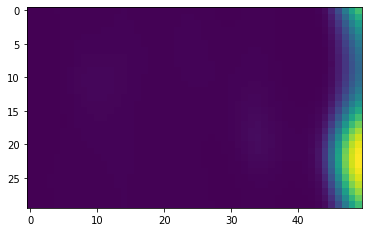

In [35]:
plt.imshow(1/mean_ISIs[..., 0, 0])

Interspike interval distributions

In [8]:
evalsteps = 120
covs_dims = covs_t.shape[-1]

cisi_t_eval = jnp.linspace(0.0, 5., evalsteps)
isi_cond = jnp.ones((neurons, ISI_orders-1))

prng_state = jr.PRNGKey(123)


x_cond = 1.*jnp.ones(covs_dims)
ISI_density = model.obs_model.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    sel_outdims=None, 
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=False,
    jitter=jitter, 
)


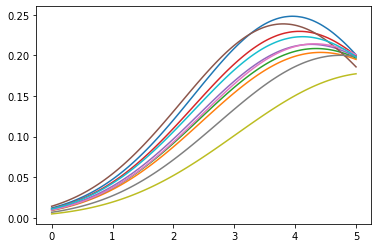

In [14]:
n = 12

plt.plot(cisi_t_eval, ISI_density[:, n, :].T)
plt.show()

Predicted intensity

In [ ]:
log_rho_t_mean, log_rho_t_cov = model.obs_model.evaluate_log_conditional_intensity(
    xs, deltas, jitter, sel_outdims)